In [46]:
import torch
from torch.utils import data
from torch import nn

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import network.modeling
from datasets import DexYCB

import utils
from utils import ext_transforms as et

from tqdm import tqdm

from PIL import Image

import os

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device to run test on: {device}')

Device to run test on: cuda


In [48]:
test_transforms = et.ExtCompose([
    # et.ExtResize( 512 ),
    et.ExtToTensor(),
    et.ExtNormalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
])

test_data = DexYCB(
    root='../DexYCB',
    setup='custom', subjects=[0,2,4,6,8], frame_stride=8, # same as training
    split='test',
    transform=test_transforms
)

In [49]:
test_loader = data.DataLoader(test_data, batch_size=1, shuffle=True, num_workers=2)

In [50]:
NUM_CLASSES = 23
MODELS = ['resnet50_scratch', 'mobilenet_scratch', 'mobilenet_separable', 'mobilenet_transfer', 'mobilenet_transfer_single']

In [51]:
images, labels = next(iter(test_loader))
images = images.to(device, dtype=torch.float32)
image, label = images[0], labels[0]

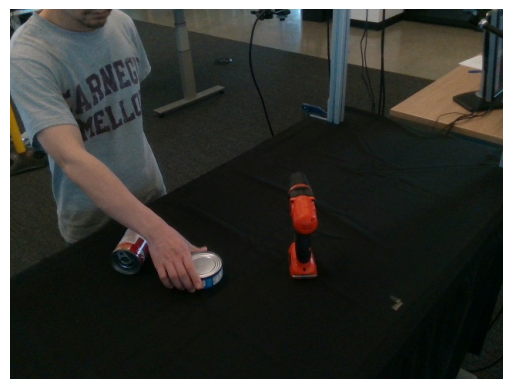

In [52]:
# Convert the tensor image to numpy for display
img_np = image.cpu().numpy()
img_np = np.transpose(img_np, (1, 2, 0))  # CHW to HWC
# Undo normalization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_np = std * img_np + mean
img_np = np.clip(img_np, 0, 1)

plt.imshow(img_np)
plt.axis('off')
plt.show()

plt.imsave('image.jpg', img_np)

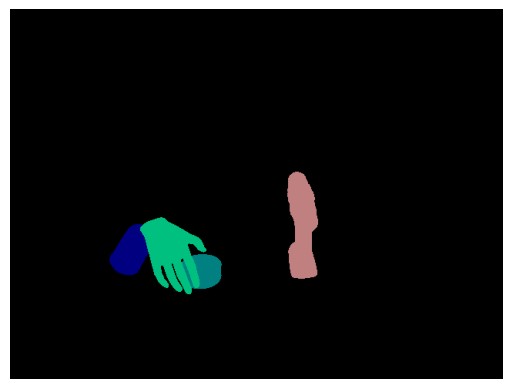

In [53]:
# Convert the tensor image to numpy for display
img_np = DexYCB.decode_target(label.cpu().numpy())

plt.imshow(img_np)
plt.axis('off')
plt.show()

plt.imsave('mask_original.png', img_np)

Testing checkpoint checkpoints/best_resnet50_scratch.pth.


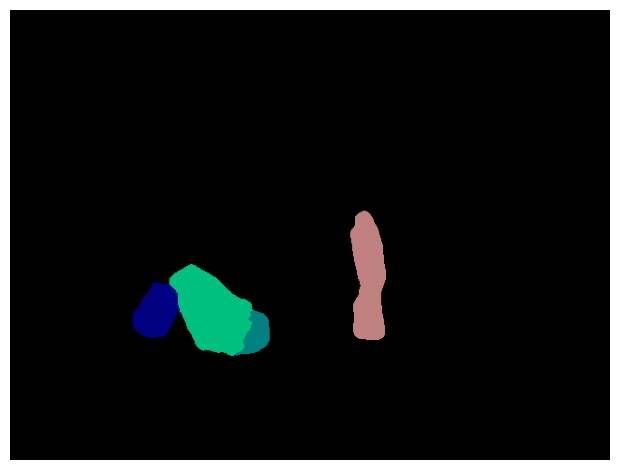

Testing checkpoint checkpoints/best_mobilenet_scratch.pth.


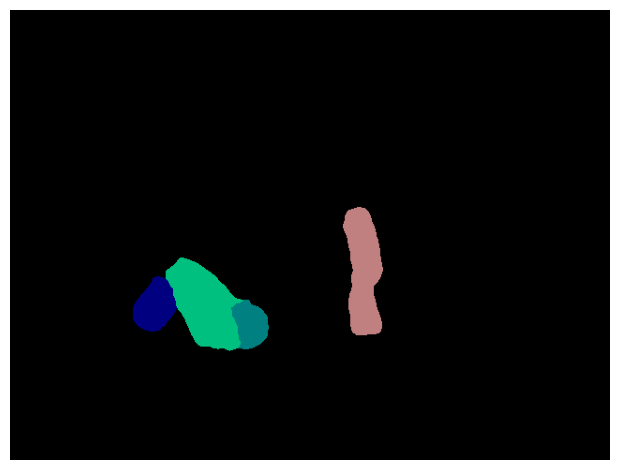

Testing checkpoint checkpoints/best_mobilenet_separable.pth.


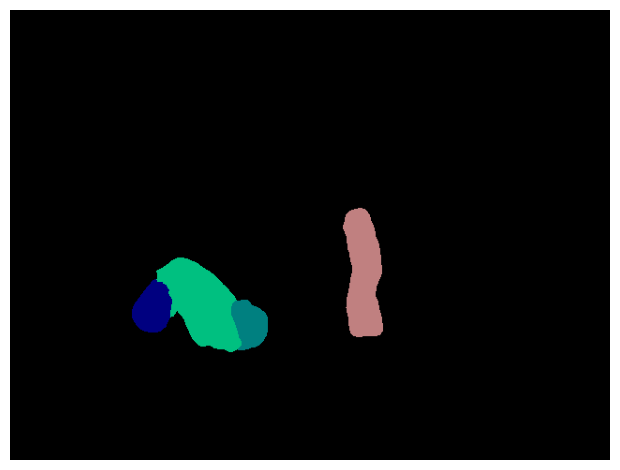

Testing checkpoint checkpoints/best_mobilenet_transfer.pth.


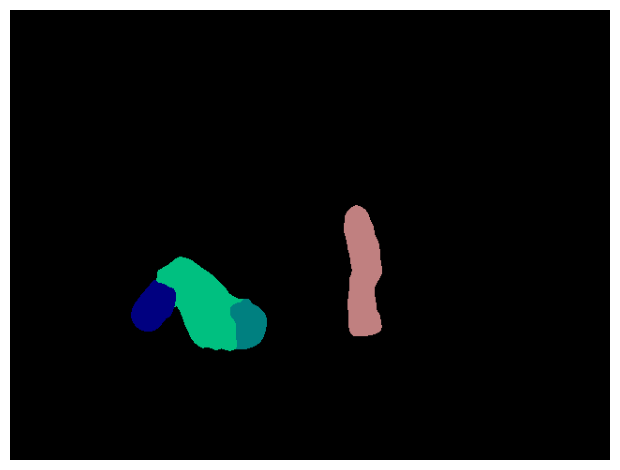

Testing checkpoint checkpoints/best_mobilenet_transfer_single.pth.


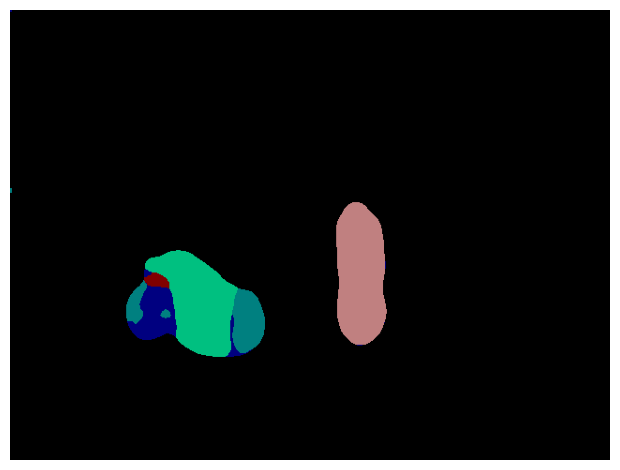

In [54]:
for model_name in MODELS:
    fname = os.path.join('checkpoints', f'best_{model_name}.pth')
    print(f'Testing checkpoint {fname}.')

    entry = {
        'Model': model_name
    }

    # set up model
    if model_name.startswith('mobilenet'): # MobileNetV2 backbone
        model = network.modeling.deeplabv3plus_mobilenet(num_classes=NUM_CLASSES)
    else: # ResNet50 backbone
        model = network.modeling.deeplabv3plus_resnet50(num_classes=NUM_CLASSES)

    if model_name.endswith('separable'): # separable convolution
        network.convert_to_separable_conv(model.classifier)

    # load checkpoint
    checkpoint = torch.load(fname, map_location=torch.device('cpu'), weights_only=False)
    model.load_state_dict(checkpoint['model_state'])
    model = nn.DataParallel(model)
    model.to(device)

    with torch.no_grad():
        model = model.eval() # run in evaluation mode
        # labels = labels.to(device, dtype=torch.long)

        outputs = model(images)

        preds = outputs.detach().max(dim=1)[1].cpu().numpy() # collapse down to [N, H, W]
        
        # Convert the tensor image to numpy for display
        img_np = DexYCB.decode_target(preds[0])

        fig, ax = plt.subplots()
        ax.imshow(img_np)
        ax.axis('off')
        plt.tight_layout()
        display(fig)
        plt.close(fig)

        plt.imsave(f'mask_{model_name}.png', img_np)